In [1]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from Image_Functions import slicing, crop_images_to_brain, crop_to_size
from datasetModule import Set
from torch import nn

Most of the functionallity is stored in module files. 
The data consist of Images with 3 channels and segmentation images with 2 channels.


In [2]:
"Need to specify the local path on computer"
dir_path = "../Task3/"

In [3]:
'Splitting the data into 30% test and 70% training.'
X_train, X_test = train_test_split(Set(dir_path, sub_dir = 'sub-23'), test_size=0.3, random_state=25)

../Task3/sub-233
../Task3/sub-232
../Task3/sub-234
../Task3/sub-230
../Task3/sub-231


In [4]:
X_train, X_test = crop_images_to_brain(X_train), crop_images_to_brain(X_test)
size = (256,288,176)
#size = (128,128,128)
X_train_c, X_test_c = crop_to_size(X_train, size), crop_to_size(X_test,size)

3
torch.Size([3, 275, 330, 168])
torch.Size([3, 275, 330, 168])
torch.Size([3, 275, 330, 168])
2
torch.Size([3, 281, 340, 182])
torch.Size([3, 281, 340, 182])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])
torch.Size([3, 256, 288, 176])
torch.Size([2, 256, 288, 176])


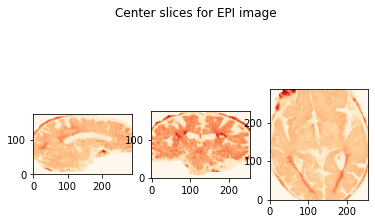

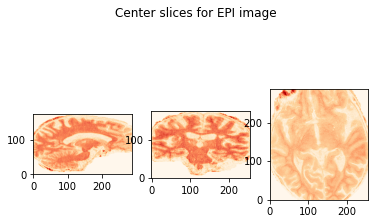

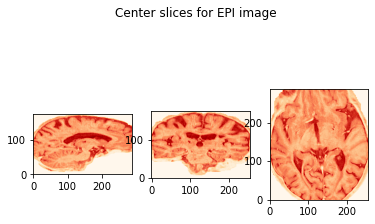

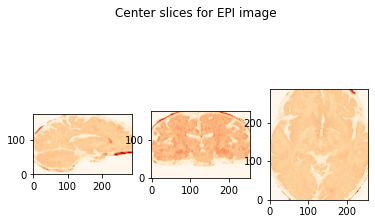

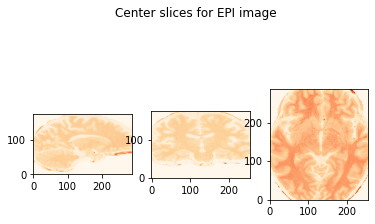

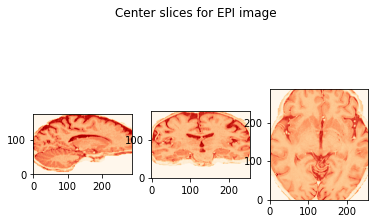

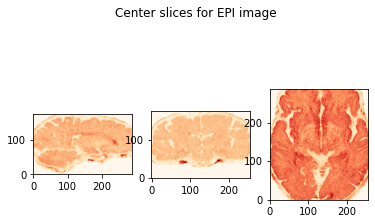

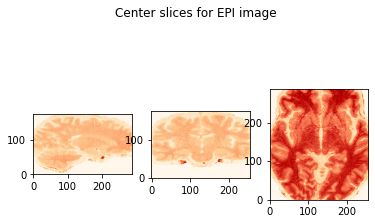

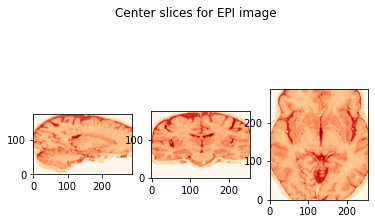

In [5]:
'Visualising slices of images along all three axis'
for i in range(len(X_train_c)):
    for j in range(3):
        img = X_train_c[i]['data'][j]
        img = img.float()
        slicing(img)

In order to access the set after they have been parsed through the dataloader:


To access a batch: batch = next(iter(<<Insert name here>>))


To access the data: batch['batchnumber']['data']


To access the segmentation: batch['batchnumber']['seg]

In [6]:
'Load training and test set, batch size may vary'
train_set, test_set = DataLoader(X_train_c, batch_size=1), DataLoader(X_test_c, batch_size=1)

In [7]:
tmp = next(iter(train_set))
image = tmp['data']
print(image.shape)
print(type(image))



torch.Size([1, 3, 256, 288, 176])
<class 'torch.Tensor'>


In [8]:
import torch
from torch import nn
from torch.nn import parameter

In [9]:



"Simple neural network with one convolution and activation"
class CNN(nn.Module):
    def __init__(self, in_channels, parameters):
        super(CNN, self).__init__()
        self.in_channels =  in_channels
        self.base_features = 32
        self.maxpool = nn.MaxPool3d
        self.upconv = nn.ConvTranspose3d
        #Layer Encode 1
        self.conv1_layer1 = self._conv_layer_set(self.in_channels, self.base_features)
        self.conv1_layer2 = self._conv_layer_set(self.base_features, self.base_features*2)
        self.maxPool1 = self.maxpool((2,2,2))

        #Layer Encode 2
        self.conv2_layer1 = self._conv_layer_set(self.base_features*2, self.base_features*2)
        self.conv2_layer2 = self._conv_layer_set(self.base_features*2, self.base_features*4)
        self.maxPool2 = self.maxpool((2,2,2))

        #Layer Encode 3
        self.conv2_layer1 = self._conv_layer_set(self.base_features*4, self.base_features*4)
        self.conv2_layer2 = self._conv_layer_set(self.base_features*4, self.base_features*8)
        self.maxPool3 = self.maxpool((2,2,2))

        #Bottom Layer
        self.conv3_layer1 = self._conv_layer_set(self.base_features*8, self.base_features*8)
        self.conv3_layer2 = self._conv_layer_set(self.base_features*8, self.base_features*16)
        self.upconv1 = self.upconv(self.base_features*16, self.base_features*16, 2, 2)

        #Decode Layer 1
        self.conv4_layer1 = self._conv_layer_set((self.base_features*8 + self.base_features*16), self.base_features*8)
        self.conv4_layer2 = self._conv_layer_set(self.base_features*8, self.base_features*8)
        self.upconv2 = self.upconv(self.base_features*8, self.base_features*8, 2, 2)

        #Decode Layer 2
        self.conv5_layer1 = self._conv_layer_set((self.base_features*4 + self.base_features*8), self.base_features*4)
        self.conv5_layer2 = self._conv_layer_set(self.base_features*4, self.base_features*4)
        self.upconv3 = self.upconv(self.base_features*4, self.base_features*4, 2, 2)

        #Decode Layer 2
        self.conv6_layer1 = self._conv_layer_set((self.base_features*2 + self.base_features*4), self.base_features*2)
        self.conv6_layer2 = self._conv_layer_set(self.base_features*2, self.base_features*2)
        self.upconv4 = self.upconv(self.base_features*2, self.base_features*2, 2, 2)

        self.final_conv = self._conv_layer_set(self.base_features*2, 1)


""" self.encoder_blocks = nn.ModuleList(self.build_block('encode'))
        self.decoder_blocks = nn.ModuleList(self.build_block('decode'))
        self.depth = 4 """
        

"""     def _conv_layer_set(self, feat_in, feat_out):
            conv_layer = nn.Sequential(
            nn.Conv3d(feat_in, feat_out, kernel_size = 3, stride=1, padding=1),
            nn.LeakyReLU(),
            )
            return conv_layer

    def encoder_block(self, feat_in, feat_out, feat_mid = None, maxpool = True):
        if feat_mid is None:
            feat_mid = feat_in
        conv1 = self._conv_layer_set(feat_in, feat_mid)
        conv2 = self._conv_layer_set(feat_mid, feat_out)
        if maxpool:
            block = nn.Sequential(conv1, conv2)
        else:
            block = nn.Sequential(conv1,conv2, nn.ConvTranspose3d(feat_out, feat_out, 2, 2))
        return block

    def decoder_block(self, feat_in, feat_out, feat_uncat = None):
        if feat_uncat is None:
            conv1 = self._conv_layer_set(feat_in, feat_out)
        else:
            conv1 = self._conv_layer_set(feat_in, feat_uncat)
        conv2 = self._conv_layer_set(feat_out, feat_out)
        block = nn.Sequential(conv1, conv2, nn.ConvTranspose3d(feat_out, feat_out, 2, 2))
        return block

    def build_block(self, path_type):
        block_list = []
        if (path_type == 'encode'):
            print('encoding')
            block_list.append(self.encoder_block(3, 64, 32))
            block_list.append(nn.MaxPool3d(2,2))
            block_list.append(self.encoder_block(64, 128))
            block_list.append(nn.MaxPool3d(2,2))
            block_list.append(self.encoder_block(128,256))
            block_list.append(nn.MaxPool3d(2,2))
            block_list.append(self.encoder_block(256, 512))
            block_list.append(nn.ConvTranspose3d(512, 512, 2, 2))
        elif (path_type == 'decode'):
            print('decoding')
            block_list.append(self.decoder_block(768, 256))
            block_list.append(self.decoder_block(384,128))
            block_list.append(self.decoder_block(192, 64))
        else: 
            print('Given wrong type')
        return block_list

    def _get_length_(self):
        print('Encoder Length: ', len(self.encoder_blocks))
        print('Decoder Length: ', len(self.decoder_blocks)) """
            
""" def forward(self, x):
        concat = []
        out = x.float()
        for d in range(len(self.encoder_blocks) - 2):
            out = self.encoder_blocks[d](out)
            if not isinstance(self.encoder_blocks[d], nn.MaxPool3d):
                concat.append(out)
        for i in range(len(concat)):
            print('Concat: ', concat[i].shape)
        out = self.encoder_blocks[-2](out)
        out = self.encoder_blocks[-1](out)
        for u in range(len(self.decoder_blocks)):
            print(concat[-1].shape)
            print(out.shape)
            out = torch.cat((concat.pop(), out), dim = 1)
            print('Concatted')
            out = self.decoder_blocks[u](out)
            print('Decode: ', out.shape)
        out = self.final_conv(out) """

def forward(self, x):
    out = x.float()
    skips = []
    #Encode Layer 1
    out = self.conv1_layer1(out)
    out = self.conv1_layer2(out)
    skips.append(out)
    out = self.maxpool1

    #Encode Layer 2
    out = self.conv2_layer1(out)
    out = self.conv2_layer2(out)
    skips.append(out)
    out = self.maxpool2

    #Encode Layer 3     

    return out

In [10]:
'Run the CNN'
model = CNN(3, None)
out_img = model(image)
print(out_img.shape)

AttributeError: 'CNN' object has no attribute '_conv_layer_set'

In [ ]:
print(out_img.shape)